# Data processing
In this notebook, a lasso model will be used to find good pre and post processing of the data, and the interpolation of missing points will be further investigated

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler,PowerTransformer
import os
import sys
import importlib

from scipy import signal

# some usefull function from the previous notebook were copied in kfold.py and models.py:
function_dir = os.path.join(os.getcwd(), 'functions')
sys.path.append(function_dir)

import kfold as kf
import models as mod
importlib.reload(kf) #to make sure the last version of kfold is used 
importlib.reload(mod) #to make sure the last version of kfold is used 

<module 'models' from 'C:\\Users\\valla\\Documents\\GitHub\\EAWAG\\Forecast\\Summary\\Baseline design\\functions\\models.py'>

In [2]:
#load the raw dataset (beforehand, it was smoothed by a 24h average rolling window)
data_path = "..\\..\\..\\Datasets\\Forecasting_aqua\\data_h_clean_v4.csv"
format = "%Y-%m-%d %H:%M:%S"
df = pd.read_csv(data_path)
time_df = pd.to_datetime(df["Datetime"], format=format)
try:
    df.drop("sample",axis=1,inplace=True)
except:
    pass
df['Datetime']= time_df
#According to the work of Stefanie Merkly, these keys were more important than the others to predict chorophill a
keys_imp = ['ciliate','mean_chla','cv_chla_day','cv_chla_depth',
            'nauplius','Ammonium','Nitrat','mean_schmidt','windspeed_max',
            'mean_thermocline_depth','mean_epi_temp','mean_oxycline_depth',
            'mean_mixed_layer_depth','mean_global_radiation'
           ]
#add some usefull variables at the end of the table
df['year'] = df['Datetime'].dt.year
df['month'] = df['Datetime'].dt.month
df['day'] = df['Datetime'].dt.day
df['hour'] = df['Datetime'].dt.hour
#drop the first datapoints the first months are only meteorological data
first_point = (~df['diatom'].isnull()).idxmax()
dfs = df.drop(index=range(first_point))
df = dfs.set_index('Datetime')

#the test part of the dataset is not used in this part
#portion of the data used for the test
test_prop = 0.15

test_len = int(len(df)*test_prop)
dftv = df[:-test_len].copy()

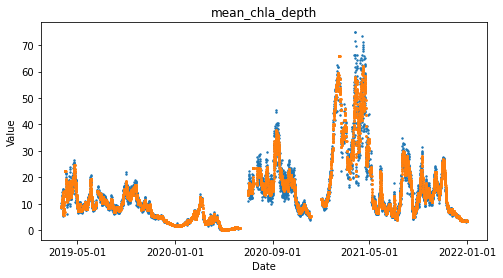

In [3]:
key = 'mean_chla_depth'

fig,ax = plt.subplots(1,figsize=(8,4))
ax.scatter(df.index,df[key],s=2)
ax.scatter(df.index,df[key].rolling('1D').mean(),s=2)
ax.set_xticks(ax.get_xticks()[0::2])
ax.set_title(f"{key}")
ax.set_xlabel("Date")
ax.set_ylabel("Value")
plt.show()

In [4]:
#lags to fit a model to
maxlag = 30
lags = np.arange(1,maxlag+1)

#input keys
in_keys = dftv.keys()

#output keys 
out_keys= ['mean_chla_depth','cluster_1']
#chose the models to compare
models = [mod.AR(out_keys,1)]
models.append(mod.AR(out_keys,15*24))
models_name = ['AR(1)','AR(360)']

#chose the data to compare:
dfs = [dftv,dftv.rolling('1D').mean()]
df_names = ['raw data','24h averaged data']
#chose the number of folds
n_fold = 10

res_model = []
tar_data = []
for df, df_name in zip(dfs,df_names):
    for model,model_name in zip(models,models_name):
        res_lag = []
        tar_lag = []
        for lag in lags:
            print(' '*70+f"lag {lag}/{lags[-1]}: "+ model_name,end= '\r')
            inputs_tv = df[in_keys][:-24*lag]
            targets_tv = df[out_keys][24*lag:].reset_index(drop=True)
            res_lag.append(kf.kfold(model,inputs_tv,targets_tv,n_fold))
            tar_lag.append(targets_tv)
        res_model.append(res_lag)
    tar_data.append(tar_lag)

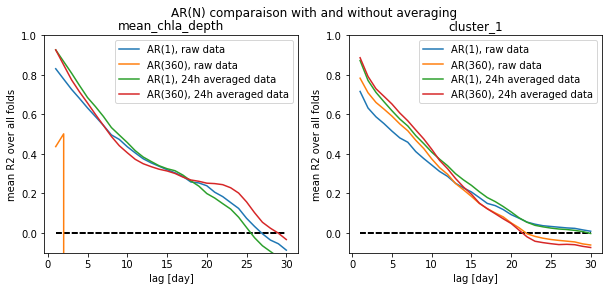

In [5]:
full_names = []
for df_name in df_names:
    full_names += [model_name+", "+df_name for model_name in models_name]
mod.R2_vs_lag(lags,res_model,[tar_lag],title='AR(N) comparaison with and without averaging',model_names = full_names)

As one can see, the data coming from the aquascope (that are sampled hourly) seems to gain a lot from being averaged in the short term. But note that this test is not really fair, as not only the inputs were averaged, but the target as well, and if some white noise is present in the data (which is a fair hypothesis), averaging over a day reduce it strongly. The next testbed is a better comparison, where the target points all have the same preprocessing:

In [6]:
#lags to fit a model to
maxlag = 30
lags = np.arange(1,maxlag+1)

#input keys
in_keys = dftv.keys()

#output keys 
out_keys= ['mean_chla_depth','cluster_1']
#chose the models to compare
models = [mod.AR(out_keys,1)]
models.append(mod.AR(out_keys,15*24))
models_name = ['AR(1)','AR(360)']

#chose the data to compare:
dfs = [dftv,dftv.rolling('1D').mean()]
df_names = ['raw data','24h averaged data']

target = dftv.rolling('1D').mean()[out_keys]
#chose the number of folds
n_fold = 10

res_model = []
tar_data = []
for df, df_name in zip(dfs,df_names):
    for model,model_name in zip(models,models_name):
        res_lag = []
        tar_lag = []
        for lag in lags:
            print(' '*70+f"lag {lag}/{lags[-1]}: "+ model_name,end= '\r')
            inputs_tv = df[in_keys][:-24*lag]
            targets_tv = target[24*lag:].reset_index(drop=True)
            res_lag.append(kf.kfold(model,inputs_tv,targets_tv,n_fold))
            tar_lag.append(targets_tv)
        res_model.append(res_lag)
    tar_data.append(tar_lag)

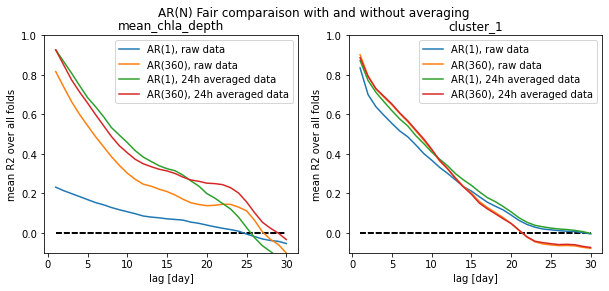

In [7]:
full_names = []
for df_name in df_names:
    full_names += [model_name+", "+df_name for model_name in models_name]
mod.R2_vs_lag(lags,res_model,[tar_lag],title='AR(N) Fair comparaison with and without averaging',model_names = full_names)

While this averaging is not improving as much as one could expect on the hourly data from the clusters, the AR(1) trained on raw data is struggling: Only one in six timestep actually linked to an input, the others are given no informations. 

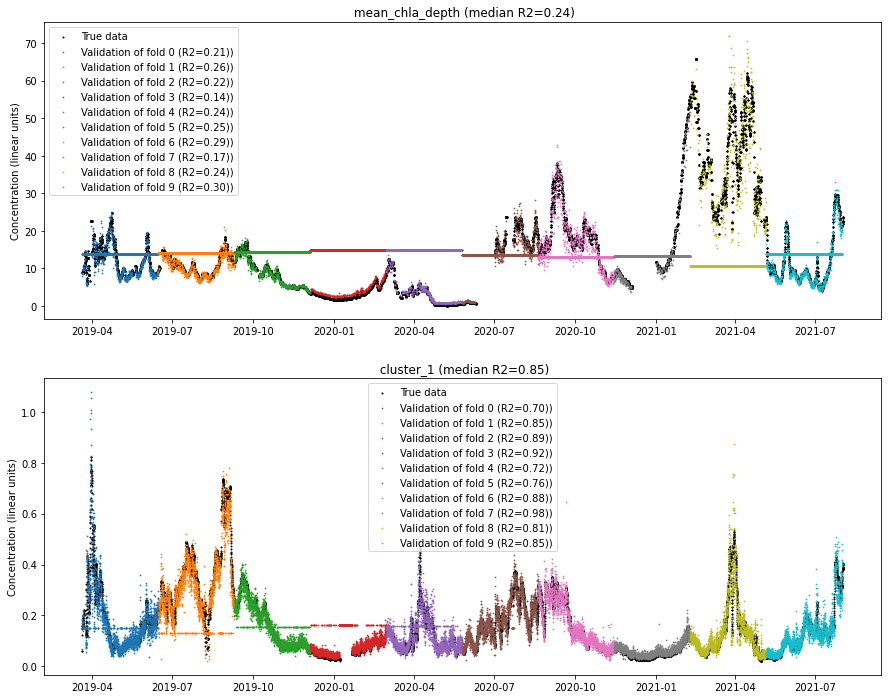

In [8]:
mod.plot_val(target,res_model[0][0])

Focussing more onto the AR(360) model, it is intersting to its weigth for both datasets:

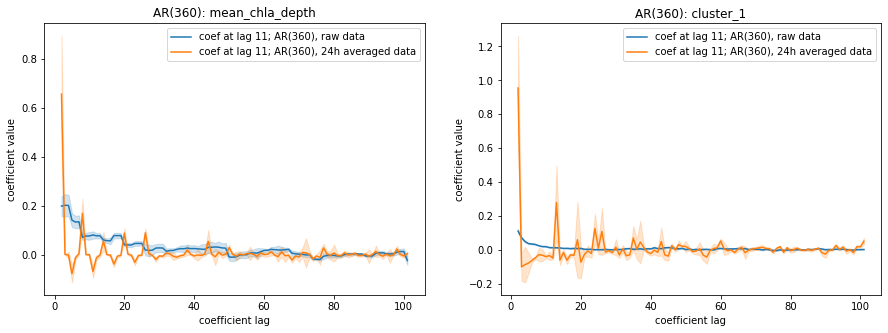

In [9]:
#check the value of the parameters:
idx_coef = 0
idx_models = [1,3]
lag = 10
maxcoef = 100

fig,axs = plt.subplots(1,len(out_keys),figsize=(15,5))
colors = ['tab:blue','tab:orange']
if len(out_keys)==1:
    axs = [axs]

for i,key in enumerate(out_keys):
    ax = axs[i]
    coefs = np.array([[res_model[idx_model][lag][fold]['model'].skmodels[i].coef_ for fold in range(n_fold) ] for idx_model in idx_models])
    coefs = coefs[:,:,-maxcoef:]
    mean = np.mean(coefs,axis=1)
    std = np.std(coefs,axis=1)
    
    ax.plot(np.arange(coefs.shape[2]+1,1,-1),mean[0:len(idx_models),:].T)
    for idx_model in range(len(idx_models)):
        ax.fill_between(np.arange(coefs.shape[2]+1,1,-1), mean[idx_model,:] - 1.96*std[idx_model,:], mean[idx_model,:]
                        + 1.96*std[idx_model,:],
                        color=colors[idx_model], alpha=0.2)
    ax.set_xlabel("coefficient lag")
    ax.set_ylabel(f"coefficient value")
    ax.set_title(models_name[idx_model]+": "+key)
    ax.legend([f"coef at lag {lag+1}; {full_names[i]}" for i in idx_models])


Interstingly, one can see that the model is effectively learning to take a weighed average, and does not use the same periodic pattern including negative weights that it can learn on the averaged data. A possible explanation for this phenomenon would be that by averaging out the high frequency noise, the model is able to catch some smaller variations.

Text(0.5, 1.0, 'mean_chla_depth')

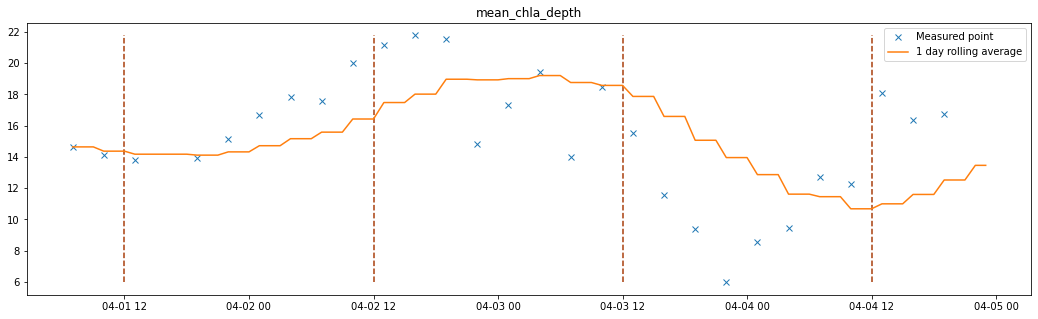

In [10]:
key = 'mean_chla_depth' #display an example
fig,ax = plt.subplots(1,1,figsize=(18,5))
dfs = dftv[(dftv.index<pd.to_datetime('2019-04-05')) & (dftv.index>pd.to_datetime('2019-04-01'))][key]
dfmean = dfs.rolling('1D').mean()
real = ax.plot(dfs,linestyle='none',marker='x')
mean = ax.plot(dfmean)
plt.vlines(dfs.index[dfs.index.hour==12],dfs.min(),dfs.max(),linestyle='dashed',color='xkcd:rust')
plt.legend(["Measured point","1 day rolling average"])
plt.title(key)


### Interpolation
To correct the shortcomming of the Markovian model, the easiest way is to use an interpolation method. This allow each and every output to have at least an approximate input. Several method are shown below

[]

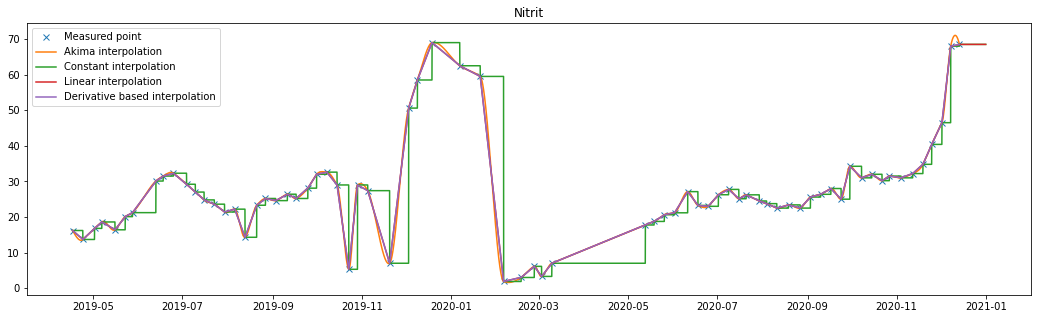

In [11]:
key = 'Nitrit' #display an example
fig,ax = plt.subplots(1,1,figsize=(18,5))
dfs = dftv[dftv.index<pd.to_datetime('2021')][key]
dfaki = dfs.interpolate(method='akima', limit_direction='forward', axis=0)
dfcons = dfs.interpolate(method='ffill',limit_direction = 'forward',axis=0)
dflin = dfs.interpolate(method='linear',limit_direction = 'forward',axis=0)
dfder = dfs.interpolate(method='from_derivatives',limit_direction = 'forward',axis=0)
real = ax.plot(dfs,linestyle='none',marker='x')
aki = ax.plot(dfaki)
cons = ax.plot(dfcons)
lin = ax.plot(dflin)
der = ax.plot(dfder)
plt.legend(["Measured point","Akima interpolation","Constant interpolation",
                                    "Linear interpolation","Derivative based interpolation"])
plt.title(key)
plt.plot()

Note that these are interpolation method, not extrapolation. This means that they use the next point to find the values of missing data. In the case of linear interpolation, a prediction result would then be biased by one sampling period, whereas other, smoother method look for points further away, leaking information from further in the future. For this reason, only the linear and constant interpolation method are used below.

As the leakage of information of the piecewise linear interpolation is bounded by the longest sampling period used in the data, as fair comparaison would add it to the lag.

In this dataset, this longest sampling period depends on the input data: the nutrients are measured weekly, the CTD data are measured 6-hourly, and the meteorological and aquascope data are measured hourly. But one should also consider the missing data occuring from time to time in the dataset, like the month of december 2020 for the chlorophill. To fully take into account this information leak, even a method as simple as a piecewise linear function is very dangerous.

In [12]:
#lags to fit a model to (note that the lag increase 3 by 3 to speed up the training)
maxlag = 30
lags = np.arange(1,maxlag+3,3)

#input keys
in_keys = dftv.keys()

#output keys 
out_keys= ['mean_chla_depth','cluster_1','Nitrit']
#chose the models to compare
models = [mod.AR(out_keys,1)]
models.append(mod.AR(out_keys,24))
models_name = ['AR(1)','AR(24)']

#chose the data to compare:
dfs = [dftv,
       dftv.rolling('1D').mean(),
       dftv.interpolate(method='ffill',limit_direction = 'forward',axis=0),
       dftv.interpolate(method='ffill',limit_direction = 'forward',axis=0).rolling('1D').mean(),
       dftv.interpolate(method='linear',limit_direction = 'forward',axis=0),
       dftv.interpolate(method='linear',limit_direction = 'forward',axis=0).rolling('1D').mean()
      ]
df_names = ['raw data','24h rolling mean','ffill','24h rmean + ffill','linear','24h rmean + linear']

target = dftv.rolling('1D').mean()[out_keys]
#chose the number of folds
n_fold = 10

res_model = []
tar_data = []
for df, df_name in zip(dfs,df_names):
    for model,model_name in zip(models,models_name):
        res_lag = []
        tar_lag = []
        for lag in lags:
            print(' '*70+f"lag {lag}/{lags[-1]}: "+ model_name,end= '\r')
            inputs_tv = df[in_keys][:-24*lag]
            targets_tv = target[24*lag:].reset_index(drop=True)
            res_lag.append(kf.kfold(model,inputs_tv,targets_tv,n_fold))
            tar_lag.append(targets_tv)
        res_model.append(res_lag)
    tar_data.append(tar_lag)

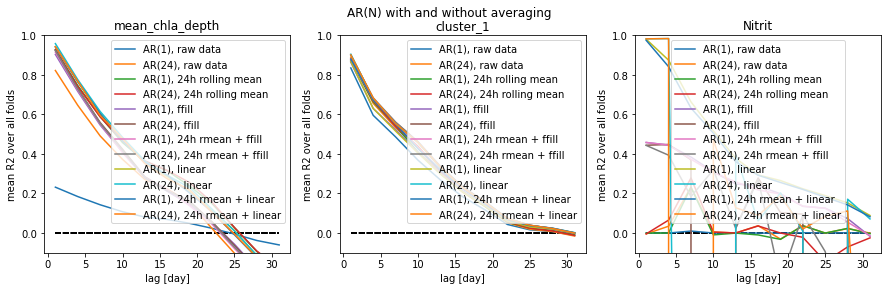

In [13]:
full_names = []
for df_name in df_names:
    full_names += [model_name+", "+df_name for model_name in models_name]
mod.R2_vs_lag(lags,res_model,[tar_lag],title='AR(N) with and without averaging',model_names = full_names)

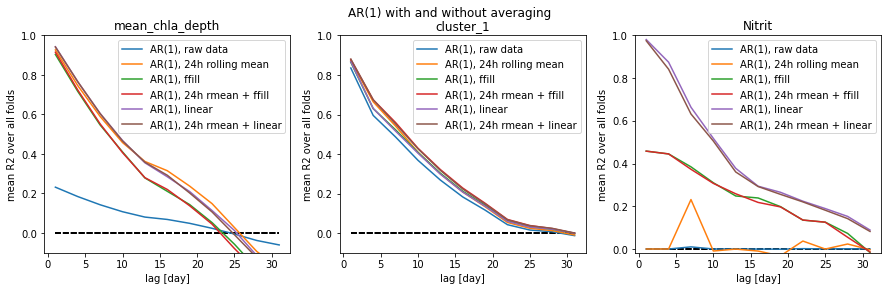

In [14]:
full_names = []
for df_name in df_names:
    full_names += [model_name+", "+df_name for model_name in models_name]
mod.R2_vs_lag(lags,res_model[0::2],[tar_lag],title='AR(1) with and without averaging',model_names = full_names[0::2])

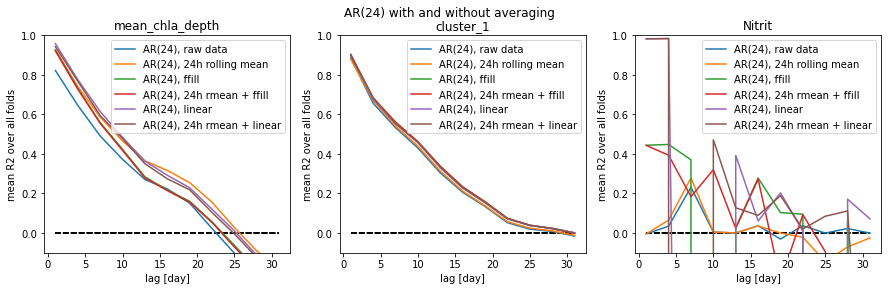

In [15]:
full_names = []
for df_name in df_names:
    full_names += [model_name+", "+df_name for model_name in models_name]
mod.R2_vs_lag(lags,res_model[1::2],[tar_lag],title='AR(24) with and without averaging',model_names = full_names[1::2])

As one can see, the interpolation does not improve the AR models, but can effectively replace the rolling average. The unfair advantage granted by the information leak of the linear interpolation is particularly visible in the nitrit concentration, where it achieves more than the double of the R2 score of the constant interpolation. Let's now see how these interpolation method would influence the behaviour of a more complex model like elastnet:

In [ ]:
#lags to fit a model to
maxlag = 30
lags = np.arange(1,maxlag+3,3)

#input keys
in_keys = dftv.keys()

#output keys 
out_keys= ['mean_chla_depth','cluster_1']
#chose the models to compare
models = [mod.AR(out_keys,1)]
models.append(mod.ElastNet(out_keys,1,freq = 1,alpha = 0.1,l1_ratio = 0.5,max_iter=50000))
models.append(mod.ElastNet(out_keys,24,freq = 3,alpha = 0.1,l1_ratio = 0.5,max_iter=50000))
#models.append(mod.ElastNet(out_keys,24,freq = 6,alpha = 0.1,l1_ratio = 0.5,max_iter=50000))
models_name = ['AR(1)','Elast(1,1)','Elast(24,3)']#,'Elast(24,6)']

#chose the data to compare:
#chose the data to compare:
dfs = [dftv,
       dftv.rolling('1D').mean(),
       dftv.interpolate(method='ffill',limit_direction = 'forward',axis=0),
       dftv.interpolate(method='ffill',limit_direction = 'forward',axis=0).rolling('1D').mean(),
       dftv.interpolate(method='linear',limit_direction = 'forward',axis=0),
       dftv.interpolate(method='linear',limit_direction = 'forward',axis=0).rolling('1D').mean()
      ]
df_names = ['raw data','24h rolling mean','ffill','24h rmean + ffill','linear','24h rmean + linear']


target = dftv.rolling('1D').mean()[out_keys]
#chose the number of folds
n_fold = 10

res_model = []
tar_data = []
for df, df_name in zip(dfs,df_names):
    for model,model_name in zip(models,models_name):
        res_lag = []
        tar_lag = []
        for lag in lags:
            print(' '*70+f"lag {lag}/{lags[-1]}: "+ model_name,end= '\r')
            inputs_tv = df[in_keys][:-24*lag]
            targets_tv = target[24*lag:].reset_index(drop=True)
            res_lag.append(kf.kfold(model,inputs_tv,targets_tv,n_fold))
            tar_lag.append(targets_tv)
        res_model.append(res_lag)
    tar_data.append(tar_lag)

In [ ]:
full_names = []
for df_name in df_names:
    full_names += [model_name+", "+df_name for model_name in models_name]
mod.R2_vs_lag(lags,res_model,[tar_lag],title='AR(N) Fair comparaison with and without averaging',model_names = full_names)

A last method that could be used to estimate these missing values would be to bootstrap a predictor in the forecasting sheme: Use the other variables available to estimate the missing ones:

Note that even though the forecasting could technically use the current data of the other variables, it is easier to restrict it to the previous ones, as it allows to train only one model for all variables.

In [ ]:
inputs = dftv[:-1].interpolate(method='ffill',limit_direction = 'forward',axis=0)
targets = dftv[1:].reset_index(drop=True)#[["mean_chla_depth"]]
importlib.reload(mod) #to make sure the last version of kfold is used 
forecaster = mod.ElastNet(list(targets.keys()),1,freq = 1,alpha = 0.2,l1_ratio = 0.9,max_iter=1000) #R2 = 0.61
#forecaster = mod.ElastNet(list(targets.keys()),2,freq = 12,alpha = 0.4,l1_ratio = 0.9,max_iter=1000) #R2 = 0.41
#forecaster = mod.ElastNet(list(targets.keys()),2,freq = 12,alpha = 0.3,l1_ratio = 0.5,max_iter=1000) #R2 = 0.49
res = kf.kfold(forecaster,inputs,targets,10)

In [ ]:
baseline_forecaster = mod.AR(list(targets.keys()),1,CP =False)
res_bl = kf.kfold(baseline_forecaster,inputs,targets,10)

In [ ]:
print(f"The prediction model was able to reach a median R2 score" +
      f" of {np.median([resi['s_val']['R2'] for resi in res]):.2f}"+
      f" over all the variables.\nReusing the last value achieved a R2 score of only"+
      f" of {np.median([resi['s_val']['R2'] for resi in res_bl]):.2f}")


To get a good overview of the efficacity of such a model, one can bootstrap it to check if the initial conditions still play a role

In [ ]:
#use the predicted values to replace the missing ones:

#first build a dataset using only the validations sets:
df_pred = dftv.copy()
for i,resi in enumerate(res):
    df_pred[1+resi['bp'][i]:1+resi['bp'][i+1]]=resi['y_predv']
    
#then fill the missing values with the predicted ones:
df_forecasted = dftv.fillna(df_pred)

In [ ]:
inputs = df_forecasted[:-1]
targets = dftv[1:].reset_index(drop=True)#[["mean_chla_depth"]]
importlib.reload(mod) #to make sure the last version of kfold is used 
forecaster_2 = mod.ElastNet(list(targets.keys()),1,freq = 1,alpha = 0.1,l1_ratio = 0.3,max_iter=1000)
res_2 = kf.kfold(forecaster,inputs,targets,10)

In [ ]:
print(f"The bootstrapped prediction model was able to reach a median R2 score" +
      f" of {np.median([resi['s_val']['R2'] for resi in res_2]):.2f}"+
      f" over all the variables.\nThe not bootstrapped one reached a median R2 score"+
      f" of {np.median([resi['s_val']['R2'] for resi in res]):.2f}")

In [ ]:
mod.plot_val(targets,res)

In [ ]:
#lags to fit a model to
maxlag = 30
lags = np.arange(1,maxlag+3,3)

#input keys
in_keys = dftv.keys()

#output keys 
out_keys= ['mean_chla_depth','cluster_1']
#chose the models to compare
models = [mod.AR(out_keys,1)]
models.append(mod.Elastnet(out_keys,1,1,alpha = 0.1))
models_name = ['AR(1)','Elast(1) alpha = 0.1']

#chose the data to compare:
dfs = [dftv.rolling("1D").mean(),df_forecasted,df_forecasted.rolling("1D").mean()]
df_names = ['1 day rmean','forecasted data','forecasted 1 day rmean']

target = dftv.rolling('1D').mean()[out_keys]
#chose the number of folds
n_fold = 10

res_model = []
tar_data = []
for df, df_name in zip(dfs,df_names):
    for model,model_name in zip(models,models_name):
        res_lag = []
        tar_lag = []
        for lag in lags:
            print(' '*70+f"lag {lag}/{lags[-1]}: "+ model_name,end= '\r')
            inputs_tv = df[in_keys][:-24*lag]
            targets_tv = target[24*lag:].reset_index(drop=True)
            res_lag.append(kf.kfold(model,inputs_tv,targets_tv,n_fold))
            tar_lag.append(targets_tv)
        res_model.append(res_lag)
    tar_data.append(tar_lag)

In [ ]:
full_names = []
for df_name in df_names:
    full_names += [model_name+", "+df_name for model_name in models_name]
mod.R2_vs_lag(lags,res_model,[tar_lag],title='Model Fair comparaison with and without forecasting',model_names = full_names)

## Time embedding
As seen in the previous notebook, the models sometimes use some time data (generally the years). However, these data are not well formated for linear regression: Their sawtooth shape can easily lead to misleading results. A better way to describe the 
time would be the following:

$ t_{noon} = sin(h*\frac{2\pi}{24})$

$ t_{sunrise} = cos(h*\frac{2\pi}{24})$

$ d_{summer} = cos((d-d_{solstice})\frac{2\pi}{365})$

$ d_{spring} = cos((d-d_{equinox})\frac{2\pi}{365})$

$ t_{global} = t-t_0 $

Where $h$ is the hour of the day, $d-d_{solstice}$ the number of days since the summer solstice, $d-d_{equinox}$ the number of days since the fall equinox and $t-t_0$ is the number of hours since the the start of the time series.
This embedding would theoretically allow a linear model to learn seasonal patterns at daily or yearly frequency, and to also account for some trend in the data. 

In [ ]:
dftv.head(4)

In [ ]:
df_tembed

In [ ]:
df_tembed = dftv.copy()
df_tembed['h_noon']=np.sin(dftv['hour']*np.pi/12)
df_tembed['h_sunrise']=np.cos(dftv['hour']*np.pi/12)
df_tembed['t_abs']= (dftv.index-dftv.index[0]).astype(int)/1e9/24/3600
d_solstice = pd.Timestamp(month=6,day=21,year = 2019)
d_dif = (dftv.index-d_solstice).astype(int)/1e9/24/3600
df_tembed['d_summer']=np.cos(d_dif*np.pi*2/365)
df_tembed['d_fall']=np.sin(d_dif*np.pi*2/365)
df_tembed = df_tembed.drop(columns=['day','year','month','hour'])

In [ ]:
key1 = ['d_summer','d_fall']
key2 = ['month','day']
start_date = pd.Timestamp("2019-04")
end_date = pd.Timestamp("2020-04")
dfplot1 = df_tembed
dfplot2 = dftv

dfplot1 = dfplot1[(dfplot1.index<end_date) & (dfplot1.index>start_date)]
dfplot2 = dfplot2[(dfplot2.index<end_date) & (dfplot2.index>start_date)]

fig,ax = plt.subplots(1,figsize=(8,4))
ax.plot((dfplot1[key1]-dfplot1[key1].min())/(dfplot1[key1].max()-dfplot1[key1].min()),linestyle='None',marker = '+',markersize=2)
ax.plot((dfplot2[key2]-dfplot2[key2].min())/(dfplot2[key2].max()-dfplot2[key2].min()),linestyle='None',marker = '+',markersize=2)
ax.set_xticks(ax.get_xticks()[0::2])
ax.set_title(f"Compare the embedding of the days")
ax.set_xlabel("Date")
ax.set_ylabel("Value")
ax.legend(key1+key2)
plt.show()

This new embedding should theoretically be better than the naive one due to its smoothness. It should nonetheless be tested experimentally:

In [ ]:
#select the keys the model should be compared on
outkeys = ['mean_chla_depth','cluster_1']
lag = 10
model = mod.Lasso(outkeys,1,alpha = 0.1)
n_fold = 10

inkeys_naive = outkeys+['day','month','year','hour']
inputs_tv = dftv[inkeys_naive][:-24*lag].rolling('1D').mean()[24:]
targets_tv = dftv.rolling('1D').mean()[outkeys][24*(lag+1):].reset_index(drop=True)
res_naive = kf.kfold(model,inputs_tv,targets_tv,n_fold)

#train the same model on the time embedded dataset
model = mod.Lasso(outkeys,1,alpha = 0.1)
inkeys_tembed  = outkeys+['t_abs','h_noon','h_sunrise','d_summer','d_fall']
inputs_tv = df_tembed[inkeys_tembed][:-24*lag].rolling('1D').mean()[24:]
targets_tv = df_tembed.rolling('1D').mean()[outkeys][24*(lag+1):].reset_index(drop=True)
res_tembed = kf.kfold(model,inputs_tv,targets_tv,n_fold)


In [ ]:
mod.plot_val(targets_tv,res_naive)

As one can see by examining the fold n°3 of the chlorophyll a concentration (in red), the prediction makes a jump where the month changes.

In [ ]:
mod.plot_val(targets_tv,res_tembed)

Here, on the other hand, this artifact disappears due to the smoothness of the embedding.

In [ ]:
#show the results:

R2_naive = np.mean([res_naivef['s_val']['R2_cat'] for res_naivef in res_naive],axis=0)
R2_tembed = np.mean([res_tembedf['s_val']['R2_cat'] for res_tembedf in res_tembed],axis=0)
for idx,key in enumerate(outkeys):
    print(f"The R2 score of the naive description for {key} is    {R2_naive[idx]:f}")
    print(f"The R2 score of the embedded description for {key} is {R2_tembed[idx]:f}")

As one can see, the explanatory power of the embedded time is better than the naive one, especially on data that shows more seasonality. This can be highlighted by observing the proportion of the fold where time data was used:

In [ ]:
mod.show_coefs(res_naive,inkeys_naive)

Here, the year and month are only used a few times over the folds

In [ ]:
mod.show_coefs(res_tembed,inkeys_tembed)

As one can see, the $d_{summer}$ and $d_{fall}$ where used in every folds to predict the cluster_1 population, and given it enabled an absolute increase of more than 16% in the $R^2$ score, one can conclude that it efficiently captured the seasonality.

# Using logarithm scale
One can try to model the environment not affecting the population of a species directly, but rather its growth rate:

$\frac{dX_i}{dt} = X_i\mu_i(t)$

where $\mu_i(t)$, the growth rate of the population i, can be modeled as a linear combination of an arbitrary function of the explanatory variables:

$\mu_i(t) = \sum_j w_{ij}X_j(t_{last})$

Note that for simplicity, it is here implied that the model is Markovian, and that $\mu(t)$ is piecewise constant between the sampling points

Such a differential equation has a solution of the form:

$X_i(t)=e^{\mu(t)t}$
To build a linear forecaster out of such a model, one can simply take the logarithm of all the variables:

$Y_i = ln(X_i)$

By using this trick, the model can now be rewritten:

$\frac{dY_i}{dt}= \frac{dX_i}{dt}\frac{ln(u)}{du}_{u=X_i}=X_i\mu_i(t)\frac{1}{X_i}=\mu_i(t)$

$\mu_i(t) = \sum_j w_{ij}X_j(t)$

This is now a linear model on $Y$. Note that the transformation is only applied to the target.



In [ ]:
#lags to fit a model to
maxlag = 30
lags = np.arange(1,maxlag+3,3)

#input keys
in_keys = dftv.keys()

#output keys 
out_keys= ['mean_chla_depth','cluster_1']
#chose the models to compare
models = [mod.AR(out_keys,1)]
models.append(mod.Elastnet(out_keys,1,1,alpha = 0.1))
models_name = ['AR(1)','Elast(1) alpha = 0.1']

#chose the data to compare:
df = [df_forecasted.rolling("1D").mean()]
df_name = ['forecasted 1 day rmean']

df_t = dftv.rolling('1D').mean()
target = np.log(df_t[out_keys])
#chose the number of folds
n_fold = 10
res_log = []
for model,model_name in zip(models,models_name):
    res_lag = []
    tar_lag = []
    for lag in lags:
        print(' '*70+f"lag {lag}/{lags[-1]}: "+ model_name,end= '\r')
        inputs_tv = df[in_keys][:-24*lag]
        targets_tv = target[24*lag:].reset_index(drop=True)
        res_lag.append(kf.kfold(model,inputs_tv,targets_tv,n_fold))
        tar_lag.append(targets_tv)
    res_log.append(res_lag)


The data could simply be fitted this way, but it would not be a fair comparison to the others models (as the effect of strong blooms would be more marked in this model. On the other hand, one can easily convert the prediction back to linear, and comparing them with the original data:

In [ ]:
res_linearized = []
for res_model in res_log:
    res_mod_lin = []
    for idx_lag,lag in enumerate(lags):
        target_tv = np.exp(tar_lag[idx_lag])
        res_lag_lin = []
        for res_fold in res_model:
            y_v  = target_tv[breakpoints[fold]:breakpoints[fold+1]]
            #define the training split
            input_t = pd.concat([input_tv[:breakpoints[fold]],input_tv[breakpoints[fold+1]:]])
            y_tr = pd.concat([target_tv[:breakpoints[fold]],target_tv[breakpoints[fold+1]:]])
            res_fold_lin = res_fold
            res_fold_lin['y_predv']=np.exp(res_fold['y_predv'])
            res_fold_lin['y_predtr']=np.exp(res_fold['y_predtr'])
            res_fold_lin['s_val']=kf.score(res_fold_lin['y_predv'], ,res_fold['mean_ytrain'])

            res_fold_lin['s_train']=kf.score(res_fold_lin['y_predtr'],
                                             df_t[res_fold['out_keys']],
                                             np.exp(res_fold['mean_ytrain']))
            res_lag_lin.append(res_fold_lin)
        res_mod_lin.append(res_lag_lin)
    res_linearized.append(res_mod_lin)

In [ ]:
mod.R2_vs_lag(lags,res_linearized,[tar_lag],
              title='Model Fair comparaison on log transformed targets',
              model_names = models_name)

### Log of the inputs:
One could consider that the concentration of the input keys are less important when they reach very high values. To test this, one could try to also take the logarithm of the input keys. The tricky part of this question is that by doing so, one can wonder about the scale of each variable, that can determine the amplitude of the attenuation:

In [ ]:
keys = ['cluster_1','cluster_8'] #display some examples
for key in keys:
    fig,ax = plt.subplots(1,1,figsize=(18,5))
    dfs = dftv[key]
    dflog = np.log(dfs)
    dflog1 = np.log(dfs+1)
    dflog10 = np.log(dfs*10+1)
    dflogmax = np.log(10*dfs/dfs.max()+1)
    real = ax.plot(dfs,linestyle='none',marker='x')
    real = ax.plot(dfs,linestyle='none',marker='x')
    plt.vlines(dfs.index[dfs.index.hour==12],dfs.min(),dfs.max(),linestyle='dashed',color='xkcd:rust')
    plt.legend(["x","log(x)","log(x+1)","log(x/mean(x))","log(x/mean(x)+1)"])
    plt.title(key)


As one can see, the log scale has some trouble to handle unnormalized data. To be sure not to leak any information from the validation, it then needs to be taken on only the training:

In [ ]:
n_fold = 10
breakpoints = np.linspace(0,len(dftv),n_fold+1,dtype=int)
dfminmax_tv = dftv.copy()

for fold in range(n_fold):
    df_t = pd.concat([dftv[:breakpoints[fold]],dftv[breakpoints[fold+1]:]])
    
    dfminmax_tv[breakpoints[fold]:breakpoints[fold+1]]= ((dftv[breakpoints[fold]:breakpoints[fold+1]]-df_t.min())/
                                                         (df_t.max()-df_t.min()))

This data can now be used to compare fairly different amplitude of logarithm:

In [ ]:
df_log10 = np.log10(9*dfminmax_tv+1) # 0<=y<=1
df_log100 =  np.log10(99*dfminmax_tv+1)# 0<=y<=2
df_log1000 =  np.log10(999*dfminmax_tv+1)# 0<=y<=3

keys = ['cluster_1','cluster_8'] #display some examples
for key in keys:
    fig,ax = plt.subplots(1,1,figsize=(18,5))
    ax.plot(df_minmax[key],linestyle='none',marker='x')
    ax.plot(df_log10[key]/2,linestyle='none',marker='x')
    ax.plot(df_log100[key]/3,linestyle='none',marker='x')
    ax.plot(df_log1000[key]/4,linestyle='none',marker='x')3"])
    plt.title(key)


In [ ]:
#lags to fit a model to
maxlag = 30
lags = np.arange(1,maxlag+3,3)

#input keys
in_keys = dftv.keys()

#output keys 
out_keys= ['mean_chla_depth','cluster_1']
#chose the models to compare
models = [mod.AR(out_keys,1)]
models.append(mod.Elastnet(out_keys,1,1,alpha = 0.1))
models_name = ['AR(1)','Elast(1) alpha = 0.1']

#chose the data to compare:
#the log is taken on all variables that are strictly positive at all time.
#the amplitude of such a log is chosen 
dfs = [dftv.rolling("1D").mean(),
       dftv
      ]
df_names = ['linear only','log only','log+linear']

target = dftv.rolling('1D').mean()[out_keys]
#chose the number of folds
n_fold = 10

res_model = []
tar_data = []
for df, df_name in zip(dfs,df_names):
    for model,model_name in zip(models,models_name):
        res_lag = []
        tar_lag = []
        for lag in lags:
            print(' '*70+f"lag {lag}/{lags[-1]}: "+ model_name,end= '\r')
            inputs_tv = df[in_keys][:-24*lag]
            targets_tv = target[24*lag:].reset_index(drop=True)
            res_lag.append(kf.kfold(model,inputs_tv,targets_tv,n_fold))
            tar_lag.append(targets_tv)
        res_model.append(res_lag)
    tar_data.append(tar_lag)